# Analyse arbitrage data we have

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [112]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Install stuff

In [1]:
!pip install pandas

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install matplotlib

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install sqlalchemy

  Using cached https://files.pythonhosted.org/packages/27/ca/c7b42794b6a6f9db4fdfb972870fa9f933f01c067634c087c8835f097daa/SQLAlchemy-1.4.14-cp37-cp37m-macosx_10_14_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/b0/42/1d66b5b61a6510f3510135d1c3b9ab0b000334c3a8a50ddcba788885dece/greenlet-1.1.0-cp37-cp37m-macosx_10_14_x86_64.whl
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
!pip install boto3

You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import sys
import os

In [4]:
aws_access_key = os.environ["GIW_AWS_ACCESS_KEY"]
aws_access_secret = os.environ["GIW_AWS_ACCESS_SECRET"]
print()

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import boto3

In [15]:
boto3.setup_default_session(profile_name="goodit")

## Load data

In [17]:
table = boto3.resource("dynamodb").Table("patron-arbitrage")

In [18]:
response = table.scan()
data = response['Items']

In [24]:
len(data)

2300

In [120]:
data[:5]

[{'roi': Decimal('0.001756636192973171'),
  'profit': Decimal('1.416366979213303'),
  'market_path': 'EPS/BTC -> BTC/USDT -> EPS/USDT',
  'market': 'EPS/BTC',
  'coin_path': 'EPS -> BTC -> USDT -> EPS',
  'timems': Decimal('1620561473483')},
 {'roi': Decimal('0.002334603798706425'),
  'profit': Decimal('1.7051946145751729'),
  'market_path': 'HOT/BUSD -> BNB/BUSD -> HOT/BNB',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> BNB -> HOT',
  'timems': Decimal('1620644621758')},
 {'roi': Decimal('0.009234737201892718'),
  'profit': Decimal('24.12021009762359'),
  'market_path': 'HOT/BUSD -> BUSD/TRY -> HOT/TRY',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> TRY -> HOT',
  'timems': Decimal('1620644622511')},
 {'roi': Decimal('0.007878453474585267'),
  'profit': Decimal('3.4554896939530986'),
  'market_path': 'HOT/BUSD -> BUSD/TRY -> HOT/TRY',
  'market': 'HOT/BUSD',
  'coin_path': 'HOT -> BUSD -> TRY -> HOT',
  'timems': Decimal('1620644623980')},
 {'roi': Decimal('0.0051547

In [33]:
df = pd.DataFrame(data)

In [34]:
df.head()

,roi,profit,market_path,market,coin_path,timems
0,0.001756636192973171,1.416366979213303,EPS/BTC -> BTC/USDT -> EPS/USDT,EPS/BTC,EPS -> BTC -> USDT -> EPS,1620561473483
1,0.002334603798706425,1.7051946145751729,HOT/BUSD -> BNB/BUSD -> HOT/BNB,HOT/BUSD,HOT -> BUSD -> BNB -> HOT,1620644621758
2,0.009234737201892718,24.12021009762359,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644622511
3,0.007878453474585267,3.4554896939530986,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644623980
4,0.005154715529422926,7.065053104627062,HOT/BUSD -> BUSD/TRY -> HOT/TRY,HOT/BUSD,HOT -> BUSD -> TRY -> HOT,1620644624637


In [40]:
df["end_market"] = df["market_path"].apply(lambda s: s.split(" -> ")[2])

In [56]:
def find_base_coin(start_market: str, end_market: str) -> str:
    coins_s = start_market.split("/")
    coins_e = end_market.split("/")
    if coins_s[0] == coins_e[0] or coins_s[0] == coins_e[1]:
        return coins_s[0]
    if coins_s[1] == coins_e[0] or coins_s[1] == coins_e[1]:
        return coins_s[1]
    raise AttributeError(f"No match between '{start_market}' and '{end_market}'")
    

In [58]:
df["coin"] = df.apply(lambda x: find_base_coin(x.market, x.end_market), axis=1)

In [74]:
len(df)

2300

In [126]:
df["profit"] = df.profit.apply(float)
df["roi"] = df.roi.apply(float)

## Total Profit

In [180]:
df_by_coin = df[["profit", "coin"]].groupby("coin").sum()

In [181]:
df_avg_by_coin = df.groupby("coin").mean()

In [182]:
df_counts_by_coin = df[["market", "coin"]].groupby("coin").count().rename(columns={"market": "arbitrage_count"})

In [183]:
df_by_coin = df_by_coin.merge(df_avg_by_coin, how="inner", on="coin", suffixes=["_total", "_avg"])

In [184]:
df_by_coin = df_by_coin.merge(df_counts_by_coin, how="inner", on="coin").reset_index()

In [185]:
df_by_coin

,coin,profit_total,roi,profit_avg,arbitrage_count
0,ACM,0.003592,0.003070,0.003592,1
1,ADA,28.163979,0.005156,0.586750,48
2,ALGO,12.776478,0.001466,0.456303,28
3,ATM,0.000650,0.000197,0.000650,1
4,AUD,1641.126686,0.007161,20.013740,82
5,AXS,8.551538,0.017590,2.137884,4
6,BAKE,0.061318,0.000990,0.015329,4
7,BNB,0.181425,0.008835,0.004652,39
8,BRL,990.096860,0.006670,12.532872,79
9,BTC,0.026684,0.009195,0.000099,269


## Convert all to USD

In [ ]:
# load tickers from S3

In [ ]:
best_usd_coins = ["BUSD", "USDT", "USDC"]

def _get_price_in_usd(coin: str) -> Optional[float]:
    pass

In [168]:
df_by_coin.sort_values("arbitrage_count", ascending=False)[:10]

,profit_total,roi,profit_avg,arbitrage_count
coin,,,,
DOGE,8855.698186,0.008779,17.854230,496
USDT,3851.644116,0.008594,13.327488,289
BTC,0.026684,0.009195,0.000099,269
BUSD,1665.680326,0.009255,6.689479,249
ETH,0.076381,0.006222,0.000606,126
TRY,7938.601367,0.010260,68.436219,116
EUR,1184.344488,0.007715,10.388987,114
RUB,14226.312371,0.005079,169.360862,84
AUD,1641.126686,0.007161,20.013740,82


## Stable Coins Profit

In [186]:
df_by_coin_stable = df_by_coin.query("coin.str.contains('BTC') or coin.str.contains('ETH') or coin.str.contains('EUR') or coin.str.contains('RUB') or coin.str.contains('USD')")

In [187]:
df_by_coin_stable.sort_values("profit_total", ascending=False)

,coin,profit_total,roi,profit_avg,arbitrage_count
36,RUB,14226.312371,0.005079,169.360862,84
42,USDT,3851.644116,0.008594,13.327488,289
10,BUSD,1665.680326,0.009255,6.689479,249
19,EUR,1184.344488,0.007715,10.388987,114
41,USDC,4.283245,0.005197,1.070811,4
39,TUSD,3.096637,0.003757,0.774159,4
18,ETH,0.076381,0.006222,0.000606,126
9,BTC,0.026684,0.009195,0.000099,269


<AxesSubplot:xlabel='coin'>

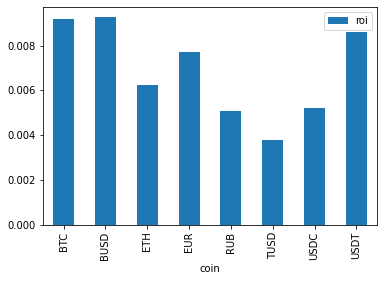

In [191]:
df_by_coin_stable.plot.bar(x="coin", y="roi")

In [122]:
# todo Calc arbitrage TTL